In [1]:
%run clean_data_en_lstm
%run clean_features

In [2]:
from collections import defaultdict, namedtuple
import numpy as np
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import duolingo_replica_alex as dr
import duolingo_replica as d
import dask.dataframe as dd

In [3]:
file_path = "C:/Users/Alexander/Dropbox/halflife_regression_rl/0_data/learning_traces.13m.csv"
result_df_en_top20 = process_data(file_path, 20)
result_df_en_top20

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,appearance_count
0,1.0,1362082504,357,u:dwbJ,en,pt,1052c3ace653dbc8923eaa183bc02b88,definition/definition<n><sg>,17,17,2,2,629
1,1.0,1362082504,357,u:dwbJ,en,pt,9cba1b30f88bf3c047b22cffcaf88c12,surface/surface<n><sg>,19,19,3,3,629
2,1.0,1362082504,357,u:dwbJ,en,pt,961cd149f20f2571419b1412d849f19a,scale/scale<n><sg>,21,20,3,3,629
3,0.8,1362082504,357,u:dwbJ,en,pt,5cbb1249562e95794a4c4ae0e2d8ae26,temperature/temperature<n><sg>,44,36,5,4,629
4,1.0,1362082504,357,u:dwbJ,en,pt,2df65bdf80d10d2b78d62cb2e0a731d8,distance/distance<n><sg>,21,20,3,3,629
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569115,1.0,1363104881,4294673,u:f_W4,en,pt,c032182c0ffb744c963ec83c937a26f4,us/prpers<prn><obj><p1><mf><pl>,10,9,1,1,35
569116,1.0,1363104881,4666611,u:f_W4,en,pt,80765ae2a08ba6812a4ab9df607b97d2,am/be<vbser><pri><p1><sg>,21,19,1,1,35
569117,0.5,1363104881,3543733,u:f_W4,en,pt,6d4c572af8022cb4784ce0f8898d1905,to/to<pr>,4,4,2,1,35
569118,1.0,1363104881,3610474,u:f_W4,en,pt,c9fb923e49d5cba24b5afb9ee1cff2a9,wine/wine<n><sg>,21,18,1,1,35


In [6]:
result_df_en_top20

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,...,lang,lexeme,right,wrong,right_this,wrong_this,bias,datetime,decimal_hours,date_only
0,1.0,1362082504,357,u:dwbJ,en,pt,1052c3ace653dbc8923eaa183bc02b88,definition/definition<n><sg>,17,17,...,pt -> en,en:definition/definition<n><sg>,4.242641,1.000000,2,0,1,2013-02-28 20:15:04,20.251111,2013-02-28
1,1.0,1362082504,357,u:dwbJ,en,pt,9cba1b30f88bf3c047b22cffcaf88c12,surface/surface<n><sg>,19,19,...,pt -> en,en:surface/surface<n><sg>,4.472136,1.000000,3,0,1,2013-02-28 20:15:04,20.251111,2013-02-28
2,1.0,1362082504,357,u:dwbJ,en,pt,961cd149f20f2571419b1412d849f19a,scale/scale<n><sg>,21,20,...,pt -> en,en:scale/scale<n><sg>,4.582576,1.414214,3,0,1,2013-02-28 20:15:04,20.251111,2013-02-28
3,0.8,1362082504,357,u:dwbJ,en,pt,5cbb1249562e95794a4c4ae0e2d8ae26,temperature/temperature<n><sg>,44,36,...,pt -> en,en:temperature/temperature<n><sg>,6.082763,3.000000,4,1,1,2013-02-28 20:15:04,20.251111,2013-02-28
4,1.0,1362082504,357,u:dwbJ,en,pt,2df65bdf80d10d2b78d62cb2e0a731d8,distance/distance<n><sg>,21,20,...,pt -> en,en:distance/distance<n><sg>,4.582576,1.414214,3,0,1,2013-02-28 20:15:04,20.251111,2013-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569115,1.0,1363104881,4294673,u:f_W4,en,pt,c032182c0ffb744c963ec83c937a26f4,us/prpers<prn><obj><p1><mf><pl>,10,9,...,pt -> en,en:us/prpers<prn><obj><p1><mf><pl>,3.162278,1.414214,1,0,1,2013-03-12 16:14:41,16.244722,2013-03-12
569116,1.0,1363104881,4666611,u:f_W4,en,pt,80765ae2a08ba6812a4ab9df607b97d2,am/be<vbser><pri><p1><sg>,21,19,...,pt -> en,en:am/be<vbser><pri><p1><sg>,4.472136,1.732051,1,0,1,2013-03-12 16:14:41,16.244722,2013-03-12
569117,0.5,1363104881,3543733,u:f_W4,en,pt,6d4c572af8022cb4784ce0f8898d1905,to/to<pr>,4,4,...,pt -> en,en:to/to<pr>,2.236068,1.000000,1,1,1,2013-03-12 16:14:41,16.244722,2013-03-12
569118,1.0,1363104881,3610474,u:f_W4,en,pt,c9fb923e49d5cba24b5afb9ee1cff2a9,wine/wine<n><sg>,21,18,...,pt -> en,en:wine/wine<n><sg>,4.358899,2.000000,1,0,1,2013-03-12 16:14:41,16.244722,2013-03-12


In [7]:
clean_data, feature_vars = read_data( result_df_en_top20, omit_lexemes = False )

In [8]:
clean_data

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,...,en:your/your<det><pos><sp>,en:yours/yours<prn><pos><mf><sp>,en:yourself/yourself<prn><ref><p2><mf><sg>,en:youth/youth<n><sg>,en:zone/zone<n><sg>,time_of_day,time_afternoon,time_evening,time_morning,time_night
0,1.0,1362082504,357,u:dwbJ,en,pt,1052c3ace653dbc8923eaa183bc02b88,definition/definition<n><sg>,17,17,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
1,1.0,1362082504,357,u:dwbJ,en,pt,9cba1b30f88bf3c047b22cffcaf88c12,surface/surface<n><sg>,19,19,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
2,1.0,1362082504,357,u:dwbJ,en,pt,961cd149f20f2571419b1412d849f19a,scale/scale<n><sg>,21,20,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
3,0.8,1362082504,357,u:dwbJ,en,pt,5cbb1249562e95794a4c4ae0e2d8ae26,temperature/temperature<n><sg>,44,36,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
4,1.0,1362082504,357,u:dwbJ,en,pt,2df65bdf80d10d2b78d62cb2e0a731d8,distance/distance<n><sg>,21,20,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569115,1.0,1363104881,4294673,u:f_W4,en,pt,c032182c0ffb744c963ec83c937a26f4,us/prpers<prn><obj><p1><mf><pl>,10,9,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
569116,1.0,1363104881,4666611,u:f_W4,en,pt,80765ae2a08ba6812a4ab9df607b97d2,am/be<vbser><pri><p1><sg>,21,19,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
569117,0.5,1363104881,3543733,u:f_W4,en,pt,6d4c572af8022cb4784ce0f8898d1905,to/to<pr>,4,4,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
569118,1.0,1363104881,3610474,u:f_W4,en,pt,c9fb923e49d5cba24b5afb9ee1cff2a9,wine/wine<n><sg>,21,18,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0


In [9]:
feature_vars_time = feature_vars + ['time_afternoon', 'time_evening', 'time_morning', 'time_night']
print(feature_vars_time)

['right', 'wrong', 'bias', "en:'/'<apos>", "en:'s/'s<gen>", 'en:<*sf>/account<n><*numb>', 'en:<*sf>/action<n><*numb>', 'en:<*sf>/activity<n><*numb>', 'en:<*sf>/actor<n><*numb>', 'en:<*sf>/advantage<n><*numb>', 'en:<*sf>/adventure<n><*numb>', 'en:<*sf>/afternoon<n><*numb>', 'en:<*sf>/age<n><*numb>', 'en:<*sf>/answer<n><*numb>', 'en:<*sf>/area<n><*numb>', 'en:<*sf>/arm<n><*numb>', 'en:<*sf>/arrival<n><*numb>', 'en:<*sf>/article<n><*numb>', 'en:<*sf>/artist<n><*numb>', 'en:<*sf>/aspect<n><*numb>', 'en:<*sf>/attack<n><*numb>', 'en:<*sf>/attorney<n><*numb>', 'en:<*sf>/august<n><*numb>', 'en:<*sf>/aunt<n><*numb>', 'en:<*sf>/author<n><*numb>', 'en:<*sf>/authority<n><*numb>', 'en:<*sf>/baby<n><*numb>', 'en:<*sf>/basket<n><*numb>', 'en:<*sf>/bathroom<n><*numb>', 'en:<*sf>/battle<n><*numb>', 'en:<*sf>/beach<n><*numb>', 'en:<*sf>/beauty<n><*numb>', 'en:<*sf>/bed<n><*numb>', 'en:<*sf>/benefit<n><*numb>', 'en:<*sf>/bicycle<n><*numb>', 'en:<*sf>/birth<n><*numb>', 'en:<*sf>/boat<n><*numb>', 'en:<*sf>

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming clean_data is your DataFrame, Y is the target column, and feature_vars are the features
# Extract unique users
unique_users = clean_data['user_id'].unique()  # Replace 'user_id' with your user identifier column

# Split users into train and test groups
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Create training and testing datasets
train_data = clean_data[clean_data['user_id'].isin(train_users)]
test_data = clean_data[clean_data['user_id'].isin(test_users)]

In [11]:
# Pre-sort the data by 'user_id' and 'datetime'
train_data.sort_values(by=['user_id', 'datetime'], inplace= True)
test_data.sort_values(by=['user_id', 'datetime'], inplace= True)

c:\Users\Alexander\anaconda3\envs\tensorflow\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [12]:
train_data.user_id.nunique()
train_data.shape

(455280, 2325)

In [13]:
import pandas as pd

# Assuming 'train_data' is your DataFrame and it includes a column 'user_id' for user identifiers
# Count the number of periods for each user
user_period_counts = train_data['user_id'].value_counts()

# Display the distribution of the counts
user_period_distribution = user_period_counts.value_counts().sort_index()
print(user_period_distribution)

20    22764
Name: user_id, dtype: int64


<AxesSubplot:>

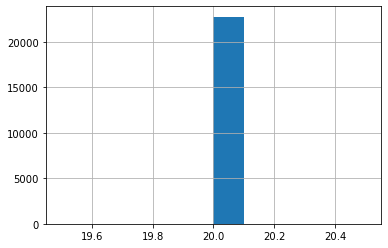

In [14]:
user_period_counts.hist()

## Create Batches so we cann run the model

In [15]:
import numpy as np

def create_non_overlapping_sequences(data, feature_vars, time_steps=20, batch_size=1000):
    # Convert feature columns to numpy for faster processing
    feature_data = data[feature_vars].to_numpy()
    output_data = data['p'].to_numpy()  # Assuming 'p' is your target variable

    # Get the starting index for each new user
    user_change_indices = np.where(data['user_id'].to_numpy()[:-1] != data['user_id'].to_numpy()[1:])[0] + 1
    user_start_indices = np.insert(user_change_indices, 0, 0)

    for batch_start in range(0, len(user_start_indices), batch_size):
        sequences = []
        outputs = []

        # Iterate through each user in the batch
        for i in range(batch_start, min(batch_start + batch_size, len(user_start_indices))):
            start_idx = user_start_indices[i]
            end_idx = start_idx + time_steps if i + 1 < len(user_start_indices) else len(feature_data)

            # Check if the user data is exactly equal to time_steps
            if end_idx - start_idx == time_steps:
                sequences.append(feature_data[start_idx:end_idx])
                outputs.append(output_data[end_idx - 1])  # Target for the last period in the sequence

        yield np.array(sequences), np.array(outputs)

# # Usage of the generator
# for X_batch, Y_batch in create_non_overlapping_sequences(train_data, feature_vars_time):
#     # Process each batch - e.g., train your model on each batch
#     pass


# LSTM BASE MODEL

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(20, len(feature_vars_time)), activation='relu'))  # Adjust units, activation
model.add(Dense(1))  # Output layer - adjust based on your problem
model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust optimizer, loss function as per your requirement

In [17]:
from tensorflow.keras.metrics import MeanAbsoluteError
import numpy as np

# Initialize the MAE metric
mae_metric = MeanAbsoluteError()
num_epochs = 10
# Train the model using the generator
for epoch in range(num_epochs):  # You can define the number of epochs
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    for X_batch, Y_batch in create_non_overlapping_sequences(train_data, feature_vars_time):
        # Train on batch and compute loss
        loss = model.train_on_batch(X_batch, Y_batch)

        # Compute MAE
        predictions = model.predict_on_batch(X_batch)
        mae_metric.update_state(Y_batch, predictions)
        mae = mae_metric.result().numpy()  # Get the MAE value

        # Reset MAE metric at the end of each batch
        mae_metric.reset_states()

        # Optionally print the loss and MAE for each batch
        print("Batch Loss: {:.4f}, Batch MAE: {:.4f}".format(loss, mae))


Epoch 1/10
Batch Loss: 1.4693, Batch MAE: 1.0925
Batch Loss: 1.2680, Batch MAE: 1.0241
Batch Loss: 1.1311, Batch MAE: 0.9759
Batch Loss: 0.9995, Batch MAE: 0.9132
Batch Loss: 0.9528, Batch MAE: 0.8951
Batch Loss: 0.8580, Batch MAE: 0.8417
Batch Loss: 0.7943, Batch MAE: 0.8173
Batch Loss: 0.7228, Batch MAE: 0.7807
Batch Loss: 0.6390, Batch MAE: 0.7287
Batch Loss: 0.5706, Batch MAE: 0.6853
Batch Loss: 0.5045, Batch MAE: 0.6411
Batch Loss: 0.4472, Batch MAE: 0.5971
Batch Loss: 0.3849, Batch MAE: 0.5421
Batch Loss: 0.3539, Batch MAE: 0.5083
Batch Loss: 0.3051, Batch MAE: 0.4729
Batch Loss: 0.2459, Batch MAE: 0.4104
Batch Loss: 0.1861, Batch MAE: 0.3402
Batch Loss: 0.1291, Batch MAE: 0.2629
Batch Loss: 0.0983, Batch MAE: 0.2190
Batch Loss: 0.1881, Batch MAE: 0.2322
Batch Loss: 0.2616, Batch MAE: 0.2909
Batch Loss: 0.4026, Batch MAE: 0.2409
Batch Loss: 0.6075, Batch MAE: 0.2997
Epoch 2/10
Batch Loss: 2.2237, Batch MAE: 0.4406
Batch Loss: 0.7426, Batch MAE: 0.3357
Batch Loss: 0.2747, Batch MA

In [18]:
# Initialize metric for testing
test_mae_metric = MeanAbsoluteError()

# Run model on test data
for X_test_batch, Y_test_batch in create_non_overlapping_sequences(test_data, feature_vars_time):
    # Make predictions
    test_predictions = model.predict_on_batch(X_test_batch)

    # Update MAE metric
    test_mae_metric.update_state(Y_test_batch, test_predictions)
    print(test_mae_metric.result())

# Calculate final MAE on test data
final_test_mae = test_mae_metric.result().numpy()
print("Final Test MAE: {:.6f}".format(final_test_mae))

tf.Tensor(0.17220834, shape=(), dtype=float32)
tf.Tensor(0.17263699, shape=(), dtype=float32)
tf.Tensor(0.17446022, shape=(), dtype=float32)
tf.Tensor(0.17172006, shape=(), dtype=float32)
tf.Tensor(0.17090695, shape=(), dtype=float32)
tf.Tensor(0.17070705, shape=(), dtype=float32)
Final Test MAE: 0.170707


# Complex Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

model = Sequential()
model.add(LSTM(100, input_shape=(20, len(feature_vars_time)), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(1, kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
from tensorflow.keras.metrics import MeanAbsoluteError
import numpy as np

# Initialize the MAE metric
mae_metric = MeanAbsoluteError()
num_epochs = 10
# Train the model using the generator
for epoch in range(num_epochs):  # You can define the number of epochs
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    for X_batch, Y_batch in create_non_overlapping_sequences(train_data, feature_vars_time):
        # Train on batch and compute loss
        loss = model.train_on_batch(X_batch, Y_batch)

        # Compute MAE
        predictions = model.predict_on_batch(X_batch)
        mae_metric.update_state(Y_batch, predictions)
        mae = mae_metric.result().numpy()  # Get the MAE value

        # Reset MAE metric at the end of each batch
        mae_metric.reset_states()

        # Optionally print the loss and MAE for each batch
        print("Batch Loss: {:.4f}, Batch MAE: {:.4f}".format(loss, mae))

Epoch 1/10
Batch Loss: 0.8097, Batch MAE: 0.6743
Batch Loss: 0.5990, Batch MAE: 0.5224
Batch Loss: 0.3869, Batch MAE: 0.3433
Batch Loss: 0.2627, Batch MAE: 0.2648
Batch Loss: 0.2530, Batch MAE: 0.3064
Batch Loss: 0.3316, Batch MAE: 0.2879
Batch Loss: 0.2762, Batch MAE: 0.2239
Batch Loss: 0.2181, Batch MAE: 0.2230
Batch Loss: 0.2054, Batch MAE: 0.2678
Batch Loss: 0.2012, Batch MAE: 0.2939
Batch Loss: 0.2152, Batch MAE: 0.3203
Batch Loss: 0.2130, Batch MAE: 0.3145
Batch Loss: 0.2166, Batch MAE: 0.3088
Batch Loss: 0.2163, Batch MAE: 0.2975
Batch Loss: 0.2157, Batch MAE: 0.2895
Batch Loss: 0.1936, Batch MAE: 0.2470
Batch Loss: 0.1810, Batch MAE: 0.2164
Batch Loss: 0.1579, Batch MAE: 0.1679
Batch Loss: 0.1633, Batch MAE: 0.1521
Batch Loss: 0.1686, Batch MAE: 0.1537
Batch Loss: 0.1966, Batch MAE: 0.1862
Batch Loss: 0.1686, Batch MAE: 0.1416
Batch Loss: 0.2037, Batch MAE: 0.1637
Epoch 2/10
Batch Loss: 0.2130, Batch MAE: 0.1772
Batch Loss: 0.1971, Batch MAE: 0.1816
Batch Loss: 0.1747, Batch MA

In [21]:
# Initialize metric for testing
test_mae_metric = MeanAbsoluteError()

# Run model on test data
for X_test_batch, Y_test_batch in create_non_overlapping_sequences(test_data, feature_vars_time):
    # Make predictions
    test_predictions = model.predict_on_batch(X_test_batch)

    # Update MAE metric
    test_mae_metric.update_state(Y_test_batch, test_predictions)
    print(test_mae_metric.result())

# Calculate final MAE on test data
final_test_mae = test_mae_metric.result().numpy()
print("Final Test MAE: {:.6f}".format(final_test_mae))

tf.Tensor(0.1711337, shape=(), dtype=float32)
tf.Tensor(0.17133206, shape=(), dtype=float32)
tf.Tensor(0.17405586, shape=(), dtype=float32)
tf.Tensor(0.17274939, shape=(), dtype=float32)
tf.Tensor(0.17320451, shape=(), dtype=float32)
tf.Tensor(0.17338769, shape=(), dtype=float32)
Final Test MAE: 0.173388


In [19]:
# Train dataset
y_train = train_data["p"]
X_train = train_data[feature_vars_time]
X_train["delta"] = train_data["t"]

# Test dataset
y_test = test_data["p"]
X_test = test_data[feature_vars_time]
X_test["delta"] = test_data["t"]

C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_24856/917030861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["delta"] = train_data["t"]
C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_24856/917030861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["delta"] = test_data["t"]


# NN Basic Model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have preprocessed your data into X (features) and y (target)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Adjust input_shape based on number of features
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)  # Adjust these parameters as needed

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

Epoch 1/20
12805/12805 [==============================] - 15s 1ms/step - loss: 0.0694 - mae: 0.1699 - val_loss: 0.0567 - val_mae: 0.1588
Epoch 2/20
12805/12805 [==============================] - 13s 984us/step - loss: 0.0643 - mae: 0.1646 - val_loss: 0.0550 - val_mae: 0.1575
Epoch 3/20
12805/12805 [==============================] - 14s 1ms/step - loss: 0.0637 - mae: 0.1638 - val_loss: 0.0553 - val_mae: 0.1538
Epoch 4/20
12805/12805 [==============================] - 14s 1ms/step - loss: 0.0635 - mae: 0.1634 - val_loss: 0.0551 - val_mae: 0.1558
Epoch 5/20
12805/12805 [==============================] - 14s 1ms/step - loss: 0.0634 - mae: 0.1632 - val_loss: 0.0550 - val_mae: 0.1577
Epoch 6/20
12805/12805 [==============================] - 15s 1ms/step - loss: 0.0633 - mae: 0.1630 - val_loss: 0.0551 - val_mae: 0.1599
Epoch 7/20
12805/12805 [==============================] - 15s 1ms/step - loss: 0.0632 - mae: 0.1629 - val_loss: 0.0550 - val_mae: 0.1540
Epoch 8/20
12805/12805 [===============

## NN Complex Model

In [22]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

Epoch 1/20
12805/12805 [==============================] - 31s 2ms/step - loss: 0.0778 - mae: 0.1825 - val_loss: 0.0557 - val_mae: 0.1585
Epoch 2/20
12805/12805 [==============================] - 29s 2ms/step - loss: 0.0642 - mae: 0.1652 - val_loss: 0.0551 - val_mae: 0.1511
Epoch 3/20
12805/12805 [==============================] - 29s 2ms/step - loss: 0.0638 - mae: 0.1643 - val_loss: 0.0550 - val_mae: 0.1549
Epoch 4/20
12805/12805 [==============================] - 29s 2ms/step - loss: 0.0637 - mae: 0.1640 - val_loss: 0.0549 - val_mae: 0.1538
Epoch 5/20
12805/12805 [==============================] - 29s 2ms/step - loss: 0.0637 - mae: 0.1639 - val_loss: 0.0550 - val_mae: 0.1522
Epoch 6/20
12805/12805 [==============================] - 28s 2ms/step - loss: 0.0636 - mae: 0.1637 - val_loss: 0.0550 - val_mae: 0.1579
Epoch 7/20
12805/12805 [==============================] - 27s 2ms/step - loss: 0.0635 - mae: 0.1636 - val_loss: 0.0550 - val_mae: 0.1561
Epoch 8/20
12805/12805 [=================

# Logistic Regression Model